#### File Setup

In [134]:
#pip install pycountry-convert --quiet
#pip install seaborn  --quiet
#pip install scipy --quiet
#pip install researchpy --quiet
#pip install statsmodels --quiet

In [2]:
import pandas as pd 
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm

In [4]:
csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/072423_results.csv"
df = pd.read_csv(csv_file)
print(df.shape)

(261, 97)


In [493]:
#df.columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 97 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   StartDate                      261 non-null    object 
 1   EndDate                        261 non-null    object 
 2   Status                         261 non-null    object 
 3   Progress                       261 non-null    int64  
 4   Duration (in seconds)          261 non-null    int64  
 5   Finished                       261 non-null    bool   
 6   RecordedDate                   261 non-null    object 
 7   ResponseId                     261 non-null    object 
 8   DistributionChannel            261 non-null    object 
 9   UserLanguage                   261 non-null    object 
 10  Q_RecaptchaScore               246 non-null    float64
 11  Q1. Metadata_Browser           261 non-null    object 
 12  Q1. Metadata_Version           261 non-null    obj

#### Basic Data Cleaning 

In [6]:
##### Data cleaning to change column types

#drop anyone not sorted into condition 
df_clean = df.drop(df[df['Condition'].isna()].index)

#change data type to int 
df_clean['Condition'] =  df_clean['Condition'].astype('int64')

# create frame column gain or loss condition based on condition value 
df_clean['frame'] = df_clean['Condition'].apply(lambda x: 'gain' if x < 3 else 'loss')

#filter only where progress = 100 
df_clean = df_clean[df_clean['Progress']==100]
print(df_clean.shape)

(242, 98)


##### Survey Time / Completion

In [7]:
df_clean['Duration (in seconds)'].describe()

count       242.000000
mean       2452.380165
std       18813.285167
min          43.000000
25%         190.000000
50%         321.500000
75%         730.500000
max      241785.000000
Name: Duration (in seconds), dtype: float64

In [943]:
## visual completion times 
#sns.histplot( y='Duration (in seconds)', data =df_clean)
#plt.show()

In [8]:

##def remove_outliers(df, column_name):
    # Calculate Z-scores for the column
    #z_scores = stats.zscore(df[column_name])
    #threshold = 3 #3 standard deviations 
    # Filter the dataframe to keep only the data within the threshold
    ##df_clean = df[abs(z_scores) < threshold]

    #return df_clean
#apply function to remove outliers 
##column_name = 'Duration (in seconds)'
##df_clean = remove_outliers(df_clean, column_name) 


# quarterlie range
quartiles = df_clean['Duration (in seconds)'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
lower_bound = quartiles[0.25] - 1.5 * iqr
upper_bound = quartiles[0.75] + 1.5 * iqr

#remove outlier
df_clean = df_clean[(df_clean['Duration (in seconds)'] >= lower_bound) & (df_clean['Duration (in seconds)'] <= upper_bound)]
df_clean.shape

(204, 98)

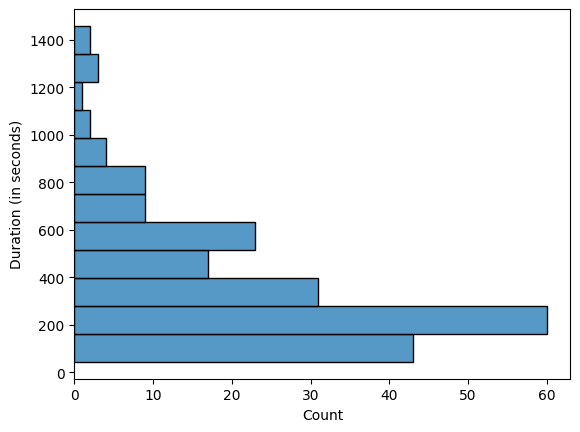

In [9]:
df_clean['Duration (in seconds)'].describe()
sns.histplot( y='Duration (in seconds)', data =df_clean)
plt.show()

In [10]:
#check for NAs
print(df.isna().sum())

StartDate                  0
EndDate                    0
Status                     0
Progress                   0
Duration (in seconds)      0
                        ... 
Q62_2_TEXT               260
Q63                       24
Q63_2_TEXT               259
Q61                      129
Condition                 15
Length: 97, dtype: int64


##### Mapping Columns & Cleaning

In [12]:
import re 
#### Creating columns and grouping for various scenarios:

#filter to option columns only
columns = df_clean.columns 
option_columns = [col for col in columns if 'Option' in col]

# dictionary mapping
scenario_dict = {"GS1":"animals_gain", "GS2":"forest_gain", "GS3":"humans_gain", "LS1":"animals_loss", "LS2":"forest_loss", "LS3":"humans_loss"  }

#set columns based on scenario 
def scenario(row):
    for col in option_columns:
        if pd.notnull(row[col]):
            match = re.search(r'(GS\d+|LS\d+)', col)
            if match:
                return match.group()
    return None

# get scenario from dictionary 
def get_scenario(row):
    value = row['scenario']
    if value in scenario_dict:
        return scenario_dict[value]
    return None

# match scenario to dict
df_clean['scenario'] = df_clean[option_columns].apply(lambda row: scenario(row), axis=1)
df_clean['scenario_mapped'] = df_clean.apply(lambda row: get_scenario(row), axis=1)


In [ ]:
##### Option Column Cleaning
# select option columns 
df_clean['option_selected'] = df_clean[option_columns].fillna(method='ffill', axis=1).iloc[:, -1]
##option_columns = ['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']

# Rating column clean & creation 
rating_columns = ['Q13. GS1, Rating','Q13. GS2, Rating', 'Q13. GS3, Rating', 'Q13. LS1, Rating', 'Q13. LS2, Rating', 'Q13. LS3, Rating']
#create a new rating column containing the non-null values of the rating columns 
df_clean['rating'] = df_clean[rating_columns].fillna(method='ffill', axis=1).iloc[:, -1]
# drop where rating is na 
df_clean = df_clean[df_clean['rating'].notna()]
# get the number only from the column 
df_clean['rating_num'] = df_clean['rating'].apply(lambda x: x.split(":")[0])
# change to integer for calculation 
df_clean['rating_num'] = df_clean['rating_num'].astype('int')

# Rationale column cleaning
rationale_columns = ['Q13. GS1, Rationale','Q14. GS2, Rationale', 'Q14. GS3, Rationle', 'Q14. LS1, Rationale', 'Q14. LS2, Rationale', 'Q14. LS3, Rationale']
# create a new rationale column containing the non-null values of the rating columns 
df_clean['rationale'] = df_clean[rationale_columns].fillna(method='ffill', axis=1).iloc[:, -1]

### Drop standalone choice, rationale, and rating columns
colu = rationale_columns + option_columns + rating_columns
df_clean = df_clean.drop(colu, axis= 'columns')
df_clean.shape

In [15]:
### Cleaning and dropping time columns ###
columns = list(df_clean.columns)

###  First click columns
time_click1 = [col for col in columns if 'first click' in col.lower()]
#time first click for the scenario 
time_click1_scn = [string for string in time_click1 if string.startswith('Q10')]
#make as 1 column 
df_clean['scn_t_first_click'] = df_clean[time_click1_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Last click columns
time_click2 = [col for col in columns if 'last click' in col.lower()]
time_click2_scn = [string for string in time_click2 if string.startswith('Q10')]
df_clean['scn_t_last_click'] = df_clean[time_click2_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Time Submit Scenario columns
time_submit = [col for col in columns if 'submit' in col.lower()]
time_submit_scn = [string for string in time_submit if string.startswith('Q10')]
df_clean['scn_t_submit'] = df_clean[time_submit_scn].fillna(method='ffill', axis=1).iloc[:, -1]

#click_count1_scn = [string for string in click_count1 if 'dem' in string.lower()]

## drop Q10 time columns 
columns_drop = time_click2_scn + time_click1_scn + time_submit_scn
df_clean = df_clean.drop(columns_drop, axis = 'columns')

##Click count cleaning 
columns = list(df_clean.columns)
## Click Count for Scenario 
click_count1 = [col for col in columns if 'click count' in col.lower()]
#filer only scenario click coun t
click_count_scn = [string for string in click_count1 if string.startswith('Q10')]
#make as 1 column for all scenarios 
df_clean['scn_click_count'] = df_clean[click_count_scn].fillna(method='ffill', axis=1).iloc[:, -1]

## Click Count for Scenario 
click_count = [col for col in columns if 'click count' in col.lower()]
click_count1_dem = [string for string in click_count if 'dem' in string.lower()]
df_clean['dem_click_count'] = df_clean[click_count1_dem].fillna(method='ffill', axis=1).iloc[:, -1]

# drop scenario and dem click count columns 
columns_drop = click_count_scn + click_count1_dem
df_clean = df_clean.drop(columns_drop, axis = 'columns')

### drop metadata or misc columns from analysis 
metadata_or_misc = ['Q1. Metadata_Browser','Q1. Metadata_Version', 'Q1. Metadata_Operating System','Q1. Metadata_Resolution', 'UserLanguage', 'DistributionChannel', 'Status']
df_clean = df_clean.drop(metadata_or_misc, axis = 'columns')


In [16]:

scenario_times = ['scn_t_first_click',  'scn_t_last_click', 'scn_t_submit']
df_clean[scenario_times]
#create column for total time for scenario question: 
df_clean['scenario_time_to_choose'] = df_clean['scn_t_last_click'] - df_clean['scn_t_first_click']
df_clean['scenario_total_time'] = df_clean['scn_t_submit'] - df_clean['scn_t_first_click']
scenario_time = ['scenario_time_to_choose', 'scenario_total_time']
df_clean[scenario_time].describe()

,scenario_time_to_choose,scenario_total_time
count,203.000000,203.000000
mean,82.723616,93.990108
std,111.909214,112.889018
min,0.489000,1.678000
25%,13.944000,24.274500
50%,45.344000,60.062000
75%,107.591500,118.370500
max,776.420000,779.137000


In [17]:
df_clean.shape

(203, 60)

### Demographics

##### Cleaning 

In [18]:
#rename columns 
df_clean = df_clean.rename(columns={
    'Q5. Age': 'age',
    'Q6. Gender': 'gender',
    'Q6. Gender_4_TEXT': 'gender_text',
    'Q8. Ethnicity': 'ethnicity',
    'Q8. Ethnicity_6_TEXT': 'ethnicity_text',
    'Q9. Education': 'education',
    'Q10. Country': 'country',
    'Q10. Student': 'student',
    'Q91': 'ADP_familiar'
})

In [19]:
###coutry name clean 
import pycountry_convert as pc

#function to rename messy countries
def rename_countries(country):
    if pd.isnull(country):  # Check if the value is nan
        return country
    if country in ['United States of America', 'USA', 'US', 'us', 'usa', 'America', 'America   ', 'the United States', 'The United States',  'United States ', 'Amrican', 'United States', 'Florida', 'New York', 'MA', 'NZ', 'North Carolina', 'Newyork', 'denver']:
        return 'USA'
    elif country in ['United Kingdom', 'United Kingdom ', 'UK', 'England', 'England ', 'Cambridge', 'London', 'uuk', 'the Netherlands']:
        return 'UK'
    elif country in ['China', '中国', 'Chinese ', '美国','加州']:
        return 'China'
    elif country in [ 'New Zealand']:
        return 'New Zealand'
    elif country in ['Paris, France', 'France']:
        return 'France'
    elif country in ['Australia', 'Australia ']:
        return 'Australia'
    elif country in ['pakistan']:
        return 'Pakistan'
    else:
        return country  # return the original name if no match is found

#update country column 
df_clean['country'] = df_clean['country'].apply(rename_countries)
#strip any remaining whitespaces
df_clean['country'] = df_clean['country'].apply(lambda x: x.strip() if isinstance(x, str) else x) #checks if string, then removes spaces 

# Map each country to the continent
def country_to_continent(country_name):
    try:
        if country_name == 'USA':
            country_alpha2 = "US"
        elif country_name == 'UK':
            country_alpha2 = "GB"
        else:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Unknown"

df_clean['continent'] = df_clean['country'].apply(country_to_continent)

In [20]:
###### Cat Code Variables #########

# ####Gender: clean gender column into numbers
#0 if female, 1 if male, 2 if non-binary 
df_clean['gender_num'] = df_clean.gender.apply(lambda x: 0 if x == 'Female' else (1 if x == 'Male' else 2))
df_clean.groupby(['gender','gender_num'])['ResponseId'].count()

####Student: clean student column into numbers
#0 if not a student, 1 if a student
df_clean['student_num']= df_clean.student.astype('category').cat.codes
df_clean.groupby(['student','student_num'])['ResponseId'].count()

####Education: clean education column into numbers
#education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
df_clean['education_num']= df_clean.education.astype('category').cat.codes
df_clean.groupby(['education','education_num'])['ResponseId'].count()

#### Ethnicity: clean ethnicity column into numbers
#ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
df_clean['ethnicity_num']= df_clean.ethnicity.astype('category').cat.codes
df_clean.groupby(['ethnicity','ethnicity_num'])['ResponseId'].count()

#### Continent: clean contintent column into numbers
#continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
df_clean['contintent_num']= df_clean.continent.astype('category').cat.codes
df_clean.groupby(['continent','contintent_num'])['ResponseId'].count()

#### ADP: lean ADP column into numbers
#ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
df_clean['ADP_num']= df_clean.ADP_familiar.astype('category').cat.codes
df_clean.groupby(['ADP_familiar','ADP_num'])['ResponseId'].count()

#### Age: clean age column into numbers
#age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}
age_order = ['18 - 24 years old', '25 - 34 years old', '35 - 44 years old', '45 - 54 years old', '55 - 64 years old']
age_mapping = {age: i for i, age in enumerate(age_order)}
df_clean['age_num'] = df_clean['age'].map(age_mapping) #maps dict 


In [21]:
## Check for NA values 
#print(df_clean[['age_num','age']].isna().value_counts())
#print(df_clean['education'].isna().value_counts())
#print('\n\n',df_clean['ADP_num'].isna().value_counts())
#df_clean['ADP_familiar'].isna().count()

# NA printing 
#print(f"""school NA: {df_clean['student'].isna().sum()}""")
#print(f"""gender NA: {df_clean['gender'].isna().sum()}""")
#print(f"""education NA: {df_clean['education'].isna().sum()}""")
#print(f"""ADP NA: {df_clean['ADP_familiar'].isna().sum()}""")
dem = ['student','education','gender','ADP_familiar']

print(df_clean[dem].isna().sum())

student         1
education       1
gender          1
ADP_familiar    4
dtype: int64


#### Demographic Insights 

Defintions
- gender_num: 0 = female, 1 = male, 2 = other
- student_num: 0 = not a studnet, 1 = a student, -1 = NA
- education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
- ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
- continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
- ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
- age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}

##### Participant Demographic Insights 

In [507]:
#Participant Demographic Insights 
demographics =   [ 'ResponseId','gender_num', 'gender', 'student_num', 'student','education_num', 'education','ethnicity_num','ethnicity', 'contintent_num', 'continent','age_num', 'age', 'ADP_num', 'ADP_familiar'] 
df_demographics = df_clean[demographics]

#ethnicity
print(df_demographics.ethnicity.value_counts(normalize=True))

ethnicity
White or Caucasian         0.710744
Asian                      0.157025
Black/African/Caribbean    0.123967
Prefer not to say          0.008264
Name: proportion, dtype: float64


In [508]:
##Demographic Insights 
#df_clean.education.value_counts(normalize = True)
#df_clean.groupby(['education_num','frame']).ResponseId.agg(['count', 'sum', 'mean','median'])
#ed = df_clean.groupby(['education_num','frame']).ResponseId.count().reset_index()
#pivoted = ed.pivot(index='education_num', columns='frame', values='ResponseId')
#df_clean[['education_num','frame']].value_counts(normalize =True)

#df_clean.groupby('continent').ResponseId.count()

In [538]:
gen_cross_tab = pd.crosstab(df_clean['gender'], df_clean['frame'])
cross_tab

frame,gain,loss
gender,,
Female,28,25
Male,28,38
Non-binary / third gender,2,1
Prefer not to say,1,0
Prefer to self-describe,1,0


In [510]:
df_clean.groupby(['age', 'age_num'])['ResponseId'].count()

age                age_num
18 - 24 years old  0          20
25 - 34 years old  1          75
35 - 44 years old  2          23
45 - 54 years old  3           3
55 - 64 years old  4           2
Name: ResponseId, dtype: int64

In [539]:
#summary insights 
df_clean.groupby(['frame','scenario','scenario_mapped','option_selected']).ResponseId.count()

#% in each condition (gain or loss)
df_clean['frame'].value_counts()


frame
loss    64
gain    59
Name: count, dtype: int64

In [ ]:
#ADP question 
df_clean['Q91'].value_counts()

### NEP Scoring

In [22]:
columns = df_clean.columns
#nep columns only
nep_columns = [col for col in columns if col.startswith('Q. NEP')]

#function to clean likert score data 
def extract_score(likert): 
   match = re.search(r'\d', likert)
   if match: 
      return int(match.group(0))
   return 0
   
# apply function to nep columns 
for col in df_clean[nep_columns]: 
   df_clean[col] = df_clean[col].astype(str)
df_clean[nep_columns] = df_clean[nep_columns].applymap(extract_score)

# function to sum score
def sum_score(row):
   if pd.notna(row).all():  #all nep questions answered
      return row.sum()
   else:
      return "N/A"

#new column that sums score
df_clean['NEP_Score'] = df_clean[nep_columns].apply(lambda row: sum_score(row), axis=1)


In [23]:
#some insights on each NEP question
stats_by_q = df_clean[nep_columns].describe().T
stats_by_q

,count,mean,std,min,25%,50%,75%,max
Q. NEP_1,203.0,2.349754,1.067447,0.0,2.0,2.0,3.0,5.0
Q. NEP_2,203.0,2.064039,0.970270,0.0,1.0,2.0,3.0,5.0
Q. NEP_3,203.0,1.970443,1.057324,0.0,1.0,2.0,3.0,5.0
Q. NEP_4,203.0,1.950739,1.047173,0.0,1.0,2.0,3.0,5.0
Q. NEP_5,203.0,1.871921,1.001657,0.0,1.0,2.0,2.0,5.0
Q. NEP_6,203.0,1.990148,1.029227,0.0,1.0,2.0,3.0,5.0
Q. NEP_7,203.0,2.128079,1.049917,0.0,1.0,2.0,3.0,5.0
Q. NEP_8,203.0,2.044335,1.091373,0.0,1.0,2.0,3.0,5.0


### Main Data Analysis 

In [24]:
main_analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating_num', 'rationale', 'age_num',  'gender_num',  'ethnicity_num', 'education_num',   'contintent_num', 'ADP_num', 'student_num','NEP_Score']
analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale',
'age', 'age_num', 'gender',  'gender_num', 'ethnicity', 'ethnicity_num', 'education', 'education_num', 'continent',  'contintent_num', 
'ADP_num','ADP_familiar',  'student', 'student_num', 'NEP_Score']


#set up dataframe 
main_analysis = df_clean[main_analysis_columns]
#remove one off na option_selection
main_analysis = main_analysis[~main_analysis['scenario_mapped'].isna()] 

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='gain']
loss_condition = main_analysis[main_analysis['frame']=='loss']

#add scenario cleaned column with just animals, humans, or forest 
main_analysis['scenario_clean'] = main_analysis['scenario_mapped'].apply(lambda x: x.split("_")[0] ) 

#% of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
print("Breakdown of Choice Selection")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")
print(f"""\n\n{frame_cross_num}""")

Breakdown of Choice Selection
Sample Size: 202
Gain Sample Size: 98
Loss Sample Size: 104


frame               gain      loss
option_selected                   
Proposal A       0.77551  0.682692
Proposal B       0.22449  0.317308


frame            gain  loss
option_selected            
Proposal A         76    71
Proposal B         22    33


In [25]:
prop_B = main_analysis[main_analysis['option_selected'] == 'Proposal B']

option_b_grouped = prop_B.groupby(['scenario_clean', 'frame']).size() / main_analysis.groupby(['frame', 'scenario_clean']).size()
option_b_grouped = option_b_grouped.to_frame().reset_index()

option_b_grouped = option_b_grouped.rename(columns={0: 'percentage'})
option_b_grouped




,scenario_clean,frame,percentage
0,animals,gain,0.242424
1,animals,loss,0.378378
2,forest,gain,0.166667
3,forest,loss,0.166667
4,humans,gain,0.275862
5,humans,loss,0.378378


In [26]:
#proportion by scenario

prop_by_scn = pd.crosstab(index = [main_analysis['frame'], main_analysis['scenario_clean']], columns = main_analysis['option_selected'], normalize='index')
print(prop_by_scn)

#proportion choosing risky choice 
prop_B = main_analysis[main_analysis['option_selected'] == 'Proposal B']


scn_prop_risky = main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc=lambda x: sum(x=='Proposal B')/len(x))

print("\n\nProportion choosing risky choice:\n",scn_prop_risky)


option_selected       Proposal A  Proposal B
frame scenario_clean                        
gain  animals           0.757576    0.242424
      forest            0.833333    0.166667
      humans            0.724138    0.275862
loss  animals           0.621622    0.378378
      forest            0.833333    0.166667
      humans            0.621622    0.378378


Proportion choosing risky choice:
 frame               gain      loss
scenario_clean                    
animals         0.242424  0.378378
forest          0.166667  0.166667
humans          0.275862  0.378378


In [27]:
scn_prop= main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc={'frame': 'count'})
scn_prop

frame,gain,loss
scenario_clean,,
animals,33,37
forest,36,30
humans,29,37


Text(0, 0.5, 'Proportion of Risky Choice')

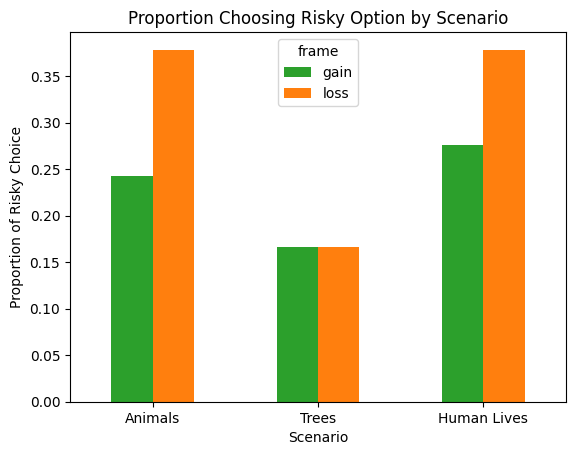

In [31]:
# Proportion Choosing Risky Option

ax = scn_prop_risky.plot(kind="bar", color = ['C2', 'C1'])
fig.set_size_inches(1, 1)

fig = ax.get_figure()
# change labels
ax.set_title("Proportion Choosing Risky Option by Scenario")
ax.set_xlabel("Scenario")
ax.set_xticklabels(labels = ['Animals', 'Trees', 'Human Lives' ], rotation = 0)
ax.set_ylabel("Proportion of Risky Choice")


In [32]:
forest = main_analysis[main_analysis['scenario_clean'] == 'forest'] 
animals = main_analysis[main_analysis['scenario_clean'] == 'forest'] 
humans = main_analysis[main_analysis['scenario_clean'] == 'forest'] 

main_analysis.groupby('scenario_clean')['NEP_Score'].describe()

,count,mean,std,min,25%,50%,75%,max
scenario_clean,,,,,,,,
animals,70.0,16.057143,6.014200,0.0,11.0,16.0,20.0,28.0
forest,66.0,16.166667,6.222993,8.0,11.0,16.0,21.0,30.0
humans,66.0,16.878788,6.133176,8.0,11.0,17.0,21.0,35.0


##### Manipulation / Attention Tests

In [ ]:
#look where rationale answer is not null 
rationale_notnull = main_analysis[~main_analysis['rationale'].isna()]
rationale_cross = pd.crosstab(rationale_notnull['option_selected'], rationale_notnull['frame'], normalize='columns')
print("Breakdown when Rationale answer is not null")
print(f"""Sample Size: {rationale_notnull.shape[0]}""")
print(f"""Gain Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'loss'].shape[0]}""")
rationale_cross

In [984]:
#look where ADP answer is not true
ADP_notyes = main_analysis[main_analysis['ADP_num'] < 2]
ADP_cross = pd.crosstab(ADP_notyes['option_selected'], ADP_notyes['frame'], normalize='columns')
print("Breakdown when ADP answer is not true")
print(f"""Sample Size: {ADP_notyes.shape[0]}""")
print(f"""Gain Sample Size: {ADP_notyes[ADP_notyes['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {ADP_notyes[ADP_notyes['frame'] == 'loss'].shape[0]}""")
ADP_cross

Breakdown when ADP answer is not true
Sample Size: 87
Gain Sample Size: 47
Loss Sample Size: 40


frame,gain,loss
option_selected,,
Proposal A,0.851064,0.625
Proposal B,0.148936,0.375


In [994]:
#look where Rating matches answer

rating_appr = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]
rating_cross = pd.crosstab(rating_appr['option_selected'], rating_appr['frame'], normalize='columns')
print("Breakdown when Rating matches answer")
print(f"""Sample Size: {rating_appr.shape[0]}""")
print(f"""Gain Sample Size: {rating_appr[rating_appr['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {rating_appr[rating_appr['frame'] == 'loss'].shape[0]}""")
rating_cross

Breakdown when Rating matches answer
Sample Size: 170
Gain Sample Size: 84
Loss Sample Size: 86


frame,gain,loss
option_selected,,
Proposal A,0.797619,0.662791
Proposal B,0.202381,0.337209


In [993]:
#Loss Condition with mismatches removed 

lossA = loss_condition[loss_condition['option_selected']=='Proposal A']
loss_filt = loss_condition[((loss_condition['option_selected']=='Proposal A') & (loss_condition['rating_num']<= 4 )) | ((loss_condition['option_selected']=='Proposal B') & (loss_condition['rating_num'] >= 4 ))]
loss_filt_cross = pd.crosstab(loss_filt['option_selected'], loss_filt['frame'], normalize='columns')
loss_filt_cross

frame,loss
option_selected,
Proposal A,0.662791
Proposal B,0.337209


In [970]:
lossB = loss_condition[loss_condition['option_selected']=='Proposal B']
lossA = loss_condition[loss_condition['option_selected']=='Proposal A']

main_analysis.isna().sum()

ResponseId          0
frame               0
scenario_mapped     1
option_selected     1
rating_num          0
rationale          44
age_num             0
gender_num          0
ethnicity_num       0
education_num       0
contintent_num      0
ADP_num             0
student_num         0
NEP_Score           0
dtype: int64

##### Plotting & Initial Tests

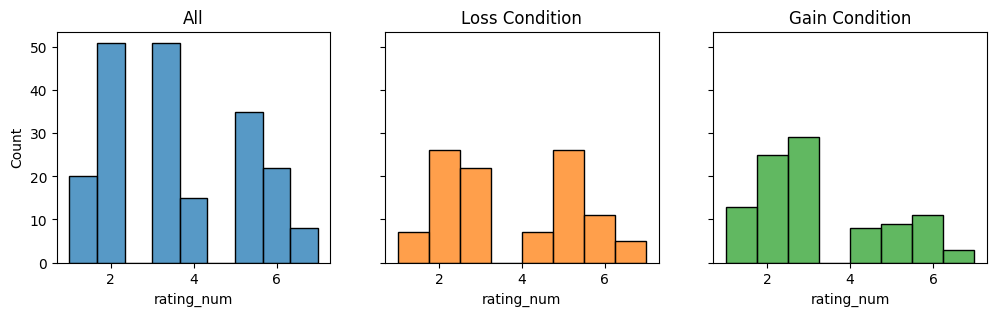

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

sns.histplot(data=main_analysis, x='rating_num', ax=axes[0], color= 'C0')
axes[0].set_title('All')
sns.histplot(data=loss_condition, x='rating_num', ax=axes[1], color= 'C1')
axes[1].set_title('Loss Condition')
sns.histplot(data=gain_condition, x='rating_num', ax=axes[2],  color= 'C2')
axes[2].set_title('Gain Condition')

plt.show()


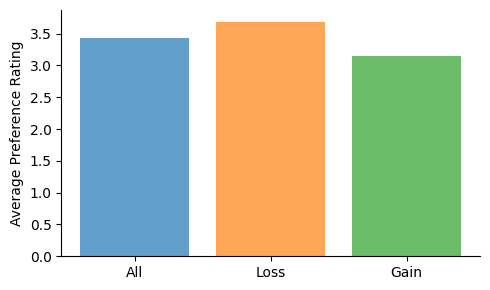

In [1007]:
##Plot graph for average rating by condition 
values = np.array([main_analysis.rating_num.mean(), loss_condition.rating_num.mean(), gain_condition.rating_num.mean(), ])
plt.figure(figsize=(5,3))
plt.bar(np.arange(3), values,  color=[ 'C0', 'C1', 'C2'], alpha=0.7, capsize=1, ecolor='dimgrey')
sns.despine()
plt.ylabel('Average Preference Rating')
plt.xticks(np.arange(3), [ 'All', 'Loss', 'Gain', ], rotation='horizontal')
plt.tight_layout()
#plt.show()

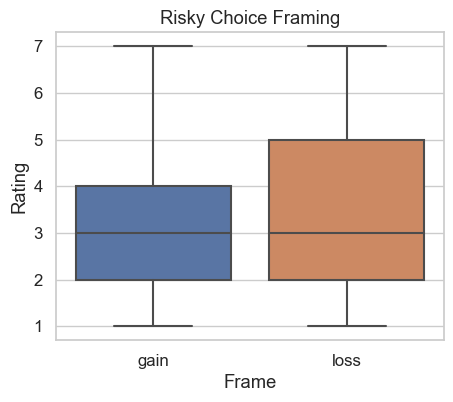

In [1041]:
sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(5,4))
sns.boxplot(x='frame', y='rating_num', data=main_analysis)
plt.title('Risky Choice Framing')
plt.xlabel('Frame')
plt.ylabel('Rating')
plt.show()

In [1001]:
print("\nAverage rating by condition & option:")
print(pd.crosstab( index = main_analysis['option_selected'], columns = main_analysis['frame'], values = main_analysis['rating_num'], aggfunc='mean'))

print("\nAverage rating by condition:")
print(main_analysis.groupby('frame').rating_num.mean())


Average rating by condition & option:
frame                gain      loss
option_selected                    
Proposal A       2.638889  2.913043
Proposal B       5.157895  5.466667

Average rating by condition:
frame
gain    3.152174
loss    3.686869
Name: rating_num, dtype: float64


In [1010]:
### look where rating matches to answer choice 
print("\nAverage rating by condition & option:")
print(pd.crosstab( index = rating_appr['option_selected'], columns = rating_appr['frame'], values = rating_appr['rating_num'], aggfunc='mean'))

print("\nAverage rating by condition:")
print(rating_appr.groupby('frame').rating_num.mean())


Average rating by condition & option:
frame                gain      loss
option_selected                    
Proposal A       2.388060  2.403509
Proposal B       5.529412  5.551724

Average rating by condition:
frame
gain    3.023810
loss    3.465116
Name: rating_num, dtype: float64


In [995]:
#ttest for experiment 

gain = main_analysis['rating_num'][main_analysis['frame'] == 'gain']
loss = main_analysis['rating_num'][main_analysis['frame'] == 'loss']

t_stat, p_value = stats.ttest_ind(gain, loss)

# results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -2.1942637779209337
P-value: 0.029435654951902902


In [36]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


In [34]:
# Calculate Cohen's d as a measure of effect size
mean_difference = gain_condition['rating_num'].mean() - loss_condition['rating_num'].mean()
#pooled_std = ((gain_condition['rating_num'].std() ** 2 + loss_condition.std() ** 2) / 2) ** 0.5
#cohen_d = mean_difference / pooled_std
#cohen_d
mean_difference

-0.4882260596546315

#### Regression & Results

In [37]:
#simple linear regression 
lin_reg = sm.OLS.from_formula('rating_num ~ frame', data = main_analysis).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))

print("\n\n\n",lin_reg.summary())


frame coeff: 0.4882260596546308
frame p-vale: 0.0391647483724627

signficicant effect? --  significant at 5% level



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.310
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0392
Time:                        17:07:27   Log-Likelihood:                -389.26
No. Observations:                 202   AIC:                             782.5
Df Residuals:                     200   BIC:                             789.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------

In [38]:
#with scenario 
reg_scn = sm.OLS.from_formula('rating_num ~ frame + scenario_clean', data = main_analysis).fit()
##reg_dem = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", reg_scn.params[1])
print("frame p-vale:", reg_scn.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_scn.pvalues[1]))
print("\n\n\n",reg_scn.summary())


frame coeff: 0.4497094631986716
frame p-vale: 0.056194212393349784

signficicant effect? significant at 10% level



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.247
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0230
Time:                        17:07:39   Log-Likelihood:                -386.57
No. Observations:                 202   AIC:                             781.1
Df Residuals:                     198   BIC:                             794.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]

In [39]:
#with basic demographic controls 
reg_dem = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", reg_dem.params[1])
print("frame p-vale:", reg_dem.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_dem.pvalues[1]))
print("\n\n\n",reg_dem.summary())


frame coeff: 0.49357730486250995
frame p-vale: 0.03827295996840963

signficicant effect? significant at 5% level



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.984
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0590
Time:                        17:08:03   Log-Likelihood:                -384.43
No. Observations:                 202   AIC:                             784.9
Df Residuals:                     194   BIC:                             811.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]


In [40]:
#with addl. demographic controls 
reg_dema = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num', data = main_analysis).fit()
print("frame coeff:", reg_dema.params[1])
print("frame p-vale:", reg_dema.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_dema.pvalues[1]))
print("\n\n",reg_dema.summary())


frame coeff: 0.47069285888021545
frame p-vale: 0.04874446987856347

signficicant effect? significant at 5% level


                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.744
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0814
Time:                        17:08:21   Log-Likelihood:                -383.48
No. Observations:                 202   AIC:                             787.0
Df Residuals:                     192   BIC:                             820.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-

In [41]:
#with ADP num 
reg_ADP = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", reg_ADP.params[1])
print("frame p-vale:", reg_ADP.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_ADP.pvalues[1]))
print("\n\n",reg_ADP.summary())


frame coeff: 0.4379709572194332
frame p-vale: 0.06561663956276027

signficicant effect? significant at 10% level


                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.927
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0437
Time:                        17:08:44   Log-Likelihood:                -381.71
No. Observations:                 202   AIC:                             785.4
Df Residuals:                     191   BIC:                             821.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-

In [42]:
#with nep scoring
reg_NEP = sm.OLS.from_formula('rating_num ~ frame : NEP_Score', data = main_analysis).fit()
print("frame coeff:", reg_NEP.params[1])
print("frame p-vale:", reg_NEP.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_NEP.pvalues[1]))
print("\n\n",reg_NEP.summary())

frame coeff: 0.006494962491980792
frame p-vale: 0.7514038600956625

signficicant effect? not significant


                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.502
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0320
Time:                        17:08:54   Log-Likelihood:                -387.92
No. Observations:                 202   AIC:                             781.8
Df Residuals:                     199   BIC:                             791.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------

In [46]:
reg_nep_interact = sm.OLS.from_formula( 'rating_num ~ frame + NEP_Score + frame: NEP_Score + scenario_clean  + age_num + gender_num + ethnicity_num + education_num', data=main_analysis).fit()
print(reg_nep_interact.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.792
Date:                Thu, 27 Jul 2023   Prob (F-statistic):             0.0720
Time:                        17:10:01   Log-Likelihood:                -383.27
No. Observations:                 202   AIC:                             786.5
Df Residuals:                     192   BIC:                             819.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [47]:
from statsmodels.iolib.summary2 import summary_col
lin_reg = sm.OLS.from_formula('rating_num ~ frame', data = main_analysis).fit()

reg_dema = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num', data = main_analysis).fit()
reg_ADP = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()

models = [lin_reg, reg_dema, reg_ADP,  reg_nep_interact ]


summary_table = summary_col(models, 
                            stars=True, 
                            float_format='%0.2f',
                            model_names=['Model w/o Covariates', 'Model w/ Basic Demographics', 'Model w/ All Demographics',  'Model w/ Interaction'],
                            info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                                       'R2': lambda x: "{:.2f}".format(x.rsquared)})

print(summary_table)

NameError: name 'smf' is not defined